# Gráficos de Cleveland: CT Izquierda vs Derecha

Este notebook genera **gráficos de Cleveland** para visualizar el Cambio de Tiempo (CT) comparando candidatos de **Izquierda** vs **Derecha** por ítem.

## Concepto:

Para cada ítem mostramos:
- **Punto azul (●)**: Tiempo promedio en candidatos de **Izquierda**
- **Punto rojo (●)**: Tiempo promedio en candidatos de **Derecha**
- **Línea conectando**: Muestra la asimetría ideológica
- **Color de línea**:
  - Azul: Mayor tiempo en Izquierda (>0.5 seg)
  - Gris: Tiempos similares (±0.5 seg)
  - Rojo: Mayor tiempo en Derecha (<-0.5 seg)

## Interpretación:

- **Valores más altos**: Mayor tiempo de respuesta
- **Línea hacia la derecha**: Más tiempo en candidatos de Izquierda
- **Línea hacia la izquierda**: Más tiempo en candidatos de Derecha
- **Hipótesis**: Diferencias pueden indicar procesamiento más deliberado según afinidad ideológica

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.lines import Line2D
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Librerías cargadas exitosamente')

✓ Librerías cargadas exitosamente


## 1. Cargar Datos

In [ ]:
# Rutas a los archivos
Ruta_Base = os.path.join(os.getcwd(), '..', 'Data', 'Bases definitivas')
Archivo_Generales = os.path.join(Ruta_Base, 'Generales.xlsx')
Archivo_Ballotage = os.path.join(Ruta_Base, 'Ballotage.xlsx')

# Cargar datos
df_Generales = pd.read_excel(Archivo_Generales)
df_Ballotage = pd.read_excel(Archivo_Ballotage)

dfs = {
    'Generales': df_Generales,
    'Ballotage': df_Ballotage
}

print(f'✓ Datos cargados:')
print(f'  - Generales: {len(df_Generales)} registros')
print(f'  - Ballotage: {len(df_Ballotage)} registros')

# Verificar columnas CT
for nombre, df in dfs.items():
    columnas_ct_izq = [col for col in df.columns if col.startswith('CT_Item_') and col.endswith('_Izq')]
    columnas_ct_der = [col for col in df.columns if col.startswith('CT_Item_') and col.endswith('_Der')]
    print(f'\n  {nombre}:')
    print(f'    Variables CT_Izq: {len(columnas_ct_izq)}')
    print(f'    Variables CT_Der: {len(columnas_ct_der)}')

## 2. Preparar Datos para Gráfico

In [ ]:
# Definir ítems
Items_Progresistas = [5, 6, 9, 11, 16, 20, 24, 25, 27, 28]
Items_Conservadores = [3, 4, 7, 8, 10, 19, 22, 23, 29, 30]
Todos_Items = sorted(Items_Progresistas + Items_Conservadores)

print(f'Total de ítems: {len(Todos_Items)}')
print(f'Ítems: {Todos_Items}')

Total de ítems: 20
Ítems: [3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30]


In [ ]:
# Calcular promedios por ítem para cada dataset
def Preparar_Datos_Por_Item(df, items):
    """
    Calcula promedios de CT_Izq y CT_Der por ítem.
    Incluye test t pareado para significancia estadística.
    """
    datos = []
    
    for item in items:
        var_izq = f'CT_Item_{item}_Izq'
        var_der = f'CT_Item_{item}_Der'
        
        if var_izq in df.columns and var_der in df.columns:
            # Calcular promedios (ignorando NaN)
            media_izq = df[var_izq].mean()
            media_der = df[var_der].mean()
            
            # Calcular diferencia (Izq - Der)
            diferencia = media_izq - media_der
            
            # Determinar tipo de ítem
            tipo = 'Progresista' if item in Items_Progresistas else 'Conservador'
            
            # Test t pareado para significancia
            datos_pareados = df[[var_izq, var_der]].dropna()
            if len(datos_pareados) > 1:
                from scipy.stats import ttest_rel
                try:
                    t_stat, p_valor = ttest_rel(datos_pareados[var_izq], 
                                                datos_pareados[var_der])
                    
                    # Determinar asteriscos de significancia
                    if p_valor < 0.001:
                        sig = '***'
                    elif p_valor < 0.01:
                        sig = '**'
                    elif p_valor < 0.05:
                        sig = '*'
                    else:
                        sig = ''
                except:
                    p_valor = np.nan
                    sig = ''
            else:
                p_valor = np.nan
                sig = ''
            
            datos.append({
                'Item': item,
                'Tipo': tipo,
                'CT_Izquierda': media_izq,
                'CT_Derecha': media_der,
                'Diferencia': diferencia,
                'p_valor': p_valor,
                'Significancia': sig
            })
    
    return pd.DataFrame(datos)

# Preparar datos para ambos datasets
datos_graficos = {}
for nombre, df in dfs.items():
    datos_graficos[nombre] = Preparar_Datos_Por_Item(df, Todos_Items)
    print(f'\n{nombre}: {len(datos_graficos[nombre])} ítems preparados')
    print(datos_graficos[nombre][['Item', 'Tipo', 'CT_Izquierda', 'CT_Derecha', 'Diferencia', 'Significancia']].head(10))


Generales: 20 ítems preparados
   Item         Tipo  CT_Izquierda  CT_Derecha  Diferencia Significancia
0     3  Conservador     -0.975119   -0.226045   -0.749074             *
1     4  Conservador     -0.959669   -0.838871   -0.120798              
2     5  Progresista     -2.603959   -2.383087   -0.220871              
3     6  Progresista     -4.299708   -3.421294   -0.878414            **
4     7  Conservador     -0.700060   -0.571451   -0.128609              
5     8  Conservador     -2.296460   -1.963645   -0.332815              
6     9  Progresista     -1.524597   -0.530097   -0.994499           ***
7    10  Conservador     -6.003483   -5.857620   -0.145863              
8    11  Progresista     -2.789548   -1.696249   -1.093299             *
9    16  Progresista     -2.725162   -2.247174   -0.477988              

Ballotage: 20 ítems preparados
   Item         Tipo  CT_Izquierda  CT_Derecha  Diferencia Significancia
0     3  Conservador     -0.803781   -1.042005    0.238225  

## 3. Función para Crear Gráfico de Cleveland

In [ ]:
def Crear_Grafico_Cleveland_CT(df, titulo, nombre_archivo=None, carpeta_destino='Graficos_Cleveland'):
    """
    Crea un gráfico de Cleveland mostrando CT Izquierda vs Derecha.
    Incluye asteriscos para indicar significancia estadística.
    """
    
    # Crear carpeta si no existe
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
    
    # Ordenar por diferencia (descendente)
    df_sorted = df.sort_values('Diferencia', ascending=True).reset_index(drop=True)
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Parámetros visuales
    y_positions = np.arange(len(df_sorted))
    
    # Dibujar líneas conectando los puntos
    for idx, row in df_sorted.iterrows():
        izq_val = row['CT_Izquierda']
        der_val = row['CT_Derecha']
        diferencia = row['Diferencia']
        
        # Determinar color de línea según diferencia
        if diferencia > 0.5:  # Más tiempo en Izquierda
            color_linea = '#3498db'  # Azul
            alpha = 0.6
        elif diferencia < -0.5:  # Más tiempo en Derecha
            color_linea = '#e74c3c'  # Rojo
            alpha = 0.6
        else:  # Diferencia pequeña
            color_linea = '#95a5a6'  # Gris
            alpha = 0.3
        
        # Dibujar línea
        ax.plot([der_val, izq_val], [idx, idx], 
                color=color_linea, linewidth=1.5, alpha=alpha, zorder=1)
    
    # Dibujar puntos de Izquierda
    ax.scatter(df_sorted['CT_Izquierda'], y_positions, 
               s=120, c='#3498db', marker='o', 
               edgecolors='white', linewidths=1.5,
               label='Izquierda', zorder=3, alpha=0.8)
    
    # Dibujar puntos de Derecha
    ax.scatter(df_sorted['CT_Derecha'], y_positions, 
               s=120, c='#e74c3c', marker='o', 
               edgecolors='white', linewidths=1.5,
               label='Derecha', zorder=3, alpha=0.8)
    
    # Configurar ejes con asteriscos de significancia
    ax.set_yticks(y_positions)
    etiquetas_con_sig = [f"Ítem {int(row['Item'])} {row['Significancia']}" if row['Significancia'] else f"Ítem {int(row['Item'])}" 
                         for _, row in df_sorted.iterrows()]
    ax.set_yticklabels(etiquetas_con_sig, fontsize=10)
    
    ax.set_xlabel('Tiempo de Respuesta (segundos)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Ítem', fontsize=12, fontweight='bold')
    ax.set_title(titulo, fontsize=14, fontweight='bold', pad=20)
    
    # Grid
    ax.grid(True, axis='x', alpha=0.3, linestyle=':', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Leyenda personalizada
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
               markersize=10, label='Izquierda', markeredgecolor='white', markeredgewidth=1),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', 
               markersize=10, label='Derecha', markeredgecolor='white', markeredgewidth=1),
        Line2D([0], [0], color='#3498db', linewidth=2, label='Más tiempo Izq (>0.5s)'),
        Line2D([0], [0], color='#95a5a6', linewidth=2, label='Similar (±0.5s)'),
        Line2D([0], [0], color='#e74c3c', linewidth=2, label='Más tiempo Der (<-0.5s)'),
        Line2D([0], [0], marker='', color='w', label='* p<0.05, ** p<0.01, *** p<0.001')
    ]
    
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10, 
              framealpha=0.95, edgecolor='gray')
    
    # Ajustar layout
    plt.tight_layout()
    
    # Guardar
    if nombre_archivo:
        ruta_completa = os.path.join(carpeta_destino, f'{nombre_archivo}.svg')
        plt.savefig(ruta_completa.replace('.png', '.svg'), format='svg', bbox_inches='tight', facecolor='white')
        print(f'✅ Gráfico guardado: {ruta_completa}')
    
    plt.show()
    
    return fig, ax

## 4. Gráficos por Dataset

Generando gráfico para Generales...

✅ Gráfico guardado: Graficos_Cleveland\Cleveland_CT_Izquierda_vs_Derecha_Generales.png


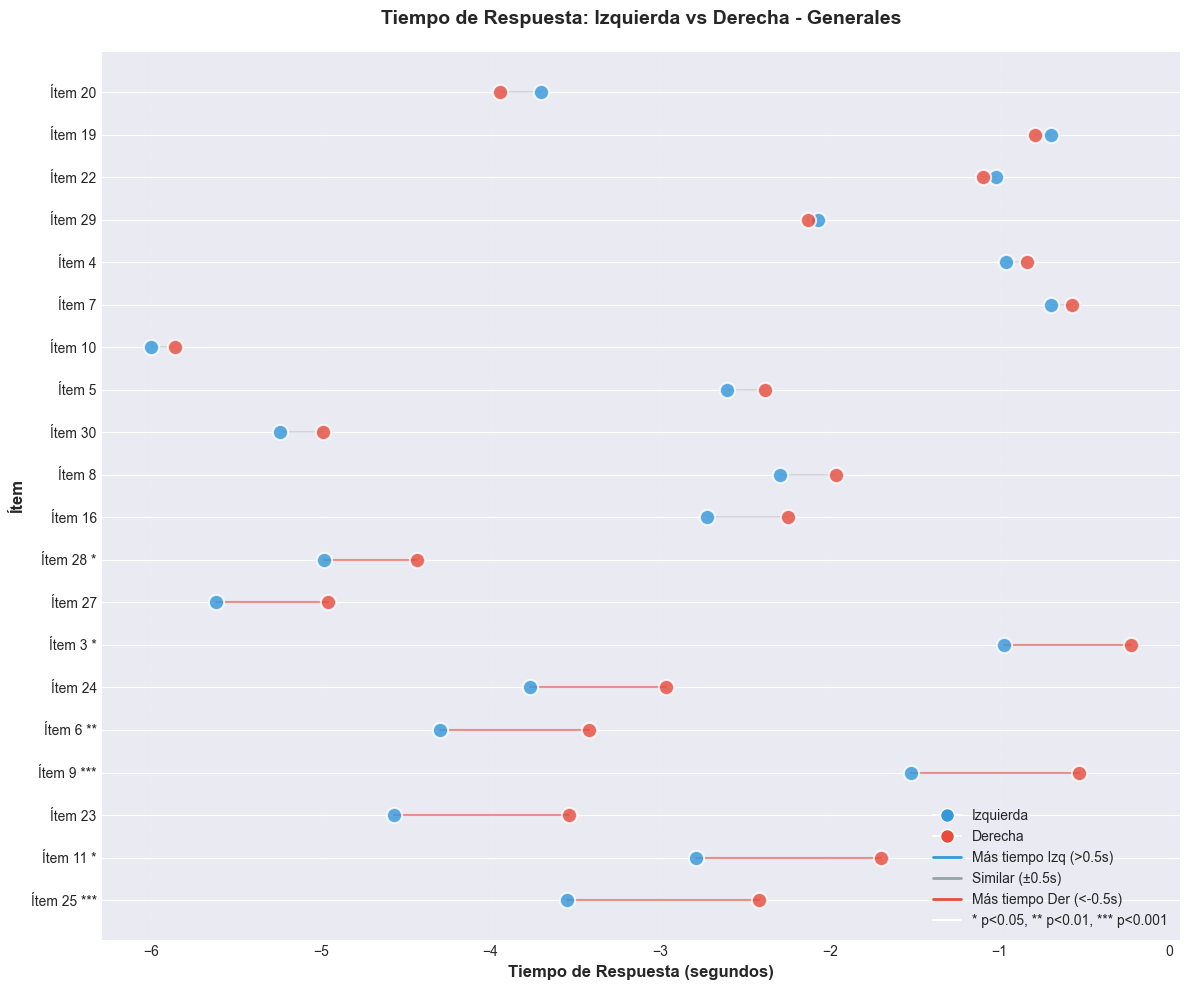

In [ ]:
# Crear gráfico para Generales
print('Generando gráfico para Generales...\n')
fig_gen, ax_gen = Crear_Grafico_Cleveland_CT(
    datos_graficos['Generales'],
    titulo='Tiempo de Respuesta: Izquierda vs Derecha - Generales',
    nombre_archivo='Cleveland_CT_Izquierda_vs_Derecha_Generales'
)

Generando gráfico para Ballotage...

✅ Gráfico guardado: Graficos_Cleveland\Cleveland_CT_Izquierda_vs_Derecha_Ballotage.png


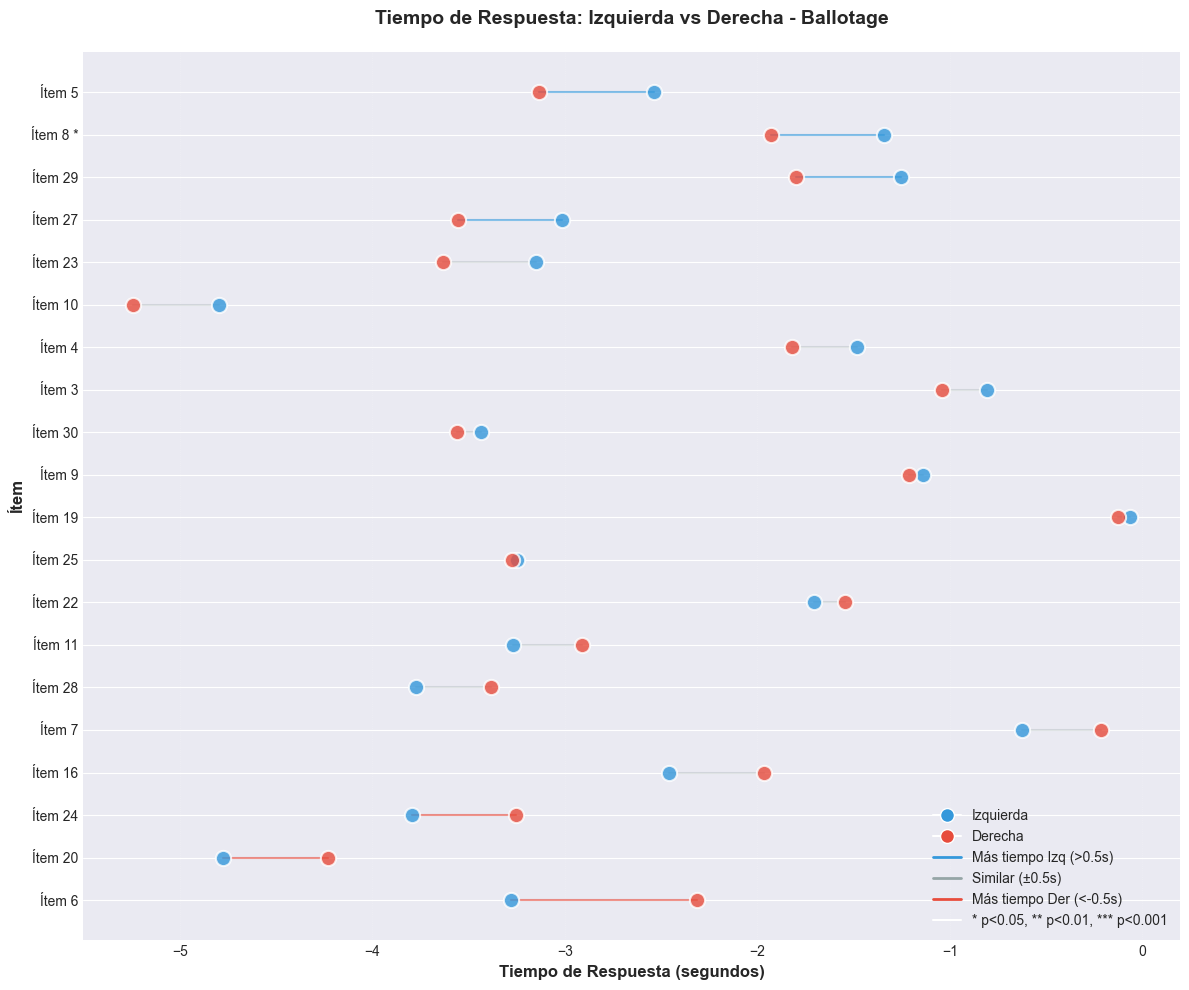

In [ ]:
# Crear gráfico para Ballotage
print('Generando gráfico para Ballotage...\n')
fig_bal, ax_bal = Crear_Grafico_Cleveland_CT(
    datos_graficos['Ballotage'],
    titulo='Tiempo de Respuesta: Izquierda vs Derecha - Ballotage',
    nombre_archivo='Cleveland_CT_Izquierda_vs_Derecha_Ballotage'
)

## 4.1. Análisis de Significancia Estadística

In [ ]:
print('='*70)
print('ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA')
print('Test t Pareado: CT Izquierda vs Derecha')
print('='*70)

for nombre, df_datos in datos_graficos.items():
    print(f'\n📊 {nombre}:')
    print('-'*70)
    
    # Filtrar ítems con significancia
    sig_items = df_datos[df_datos['Significancia'] != ''].copy()
    
    if len(sig_items) > 0:
        print(f'\n✅ Ítems con diferencias significativas: {len(sig_items)}/{len(df_datos)}')
        
        # Separar por dirección
        sig_mas_izq = sig_items[sig_items['Diferencia'] > 0]
        sig_mas_der = sig_items[sig_items['Diferencia'] < 0]
        
        if len(sig_mas_izq) > 0:
            print(f'\n  Más tiempo en IZQUIERDA ({len(sig_mas_izq)} ítems):')
            for _, row in sig_mas_izq.iterrows():
                print(f"    {row['Significancia']:3s} Ítem {int(row['Item']):2d} ({row['Tipo']:12s}) | Dif: {row['Diferencia']:6.3f}s | p={row['p_valor']:.4f}")
        
        if len(sig_mas_der) > 0:
            print(f'\n  Más tiempo en DERECHA ({len(sig_mas_der)} ítems):')
            for _, row in sig_mas_der.iterrows():
                print(f"    {row['Significancia']:3s} Ítem {int(row['Item']):2d} ({row['Tipo']:12s}) | Dif: {row['Diferencia']:6.3f}s | p={row['p_valor']:.4f}")
    else:
        print('\n❌ No hay ítems con diferencias significativas (p < 0.05)')
    
    # Ítems no significativos
    no_sig = df_datos[df_datos['Significancia'] == '']
    if len(no_sig) > 0:
        print(f'\n⚪ Ítems sin diferencias significativas: {len(no_sig)}/{len(df_datos)}')
    
    print('\n' + '-'*70)

print('\n' + '='*70)
print('Niveles de significancia: * p<0.05, ** p<0.01, *** p<0.001')
print('='*70)

ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA
Test t Pareado: CT Izquierda vs Derecha

📊 Generales:
----------------------------------------------------------------------

✅ Ítems con diferencias significativas: 6/20

  Más tiempo en DERECHA (6 ítems):
    *   Ítem  3 (Conservador ) | Dif: -0.749s | p=0.0113
    **  Ítem  6 (Progresista ) | Dif: -0.878s | p=0.0035
    *** Ítem  9 (Progresista ) | Dif: -0.994s | p=0.0005
    *   Ítem 11 (Progresista ) | Dif: -1.093s | p=0.0270
    *** Ítem 25 (Progresista ) | Dif: -1.128s | p=0.0002
    *   Ítem 28 (Progresista ) | Dif: -0.543s | p=0.0196

⚪ Ítems sin diferencias significativas: 14/20

----------------------------------------------------------------------

📊 Ballotage:
----------------------------------------------------------------------

✅ Ítems con diferencias significativas: 1/20

  Más tiempo en IZQUIERDA (1 ítems):
    *   Ítem  8 (Conservador ) | Dif:  0.585s | p=0.0455

⚪ Ítems sin diferencias significativas: 19/20

--------------------

## 5. Análisis Estadístico de Diferencias

In [ ]:
print('='*70)
print('ANÁLISIS: CT IZQUIERDA VS DERECHA')
print('='*70)

for nombre, df_datos in datos_graficos.items():
    print(f'\n📊 {nombre}:')
    print('-'*70)
    
    print(f'\nEstadísticas Generales:')
    print(f'  Promedio CT_Izquierda: {df_datos["CT_Izquierda"].mean():.3f} seg')
    print(f'  Promedio CT_Derecha: {df_datos["CT_Derecha"].mean():.3f} seg')
    print(f'  Diferencia promedio (Izq - Der): {df_datos["Diferencia"].mean():.3f} seg')
    
    print(f'\nDistribución de Diferencias:')
    mayor_izq = len(df_datos[df_datos['Diferencia'] > 0.5])
    similares = len(df_datos[(df_datos['Diferencia'] >= -0.5) & (df_datos['Diferencia'] <= 0.5)])
    mayor_der = len(df_datos[df_datos['Diferencia'] < -0.5])
    
    print(f'  Mayor tiempo en Izquierda (>0.5s): {mayor_izq} ítems ({mayor_izq/len(df_datos)*100:.1f}%)')
    print(f'  Similar (±0.5s): {similares} ítems ({similares/len(df_datos)*100:.1f}%)')
    print(f'  Mayor tiempo en Derecha (<-0.5s): {mayor_der} ítems ({mayor_der/len(df_datos)*100:.1f}%)')
    
    print(f'\nTop 5 Ítems con MÁS tiempo en Izquierda:')
    print('-'*70)
    top_izq = df_datos.nlargest(5, 'Diferencia')[['Item', 'Tipo', 'CT_Izquierda', 'CT_Derecha', 'Diferencia']]
    print(top_izq.to_string(index=False))
    
    print(f'\nTop 5 Ítems con MÁS tiempo en Derecha:')
    print('-'*70)
    top_der = df_datos.nsmallest(5, 'Diferencia')[['Item', 'Tipo', 'CT_Izquierda', 'CT_Derecha', 'Diferencia']]
    print(top_der.to_string(index=False))
    
    print('\n' + '-'*70)

print('\n' + '='*70)

ANÁLISIS: CT IZQUIERDA VS DERECHA

📊 Generales:
----------------------------------------------------------------------

Estadísticas Generales:
  Promedio CT_Izquierda: -3.005 seg
  Promedio CT_Derecha: -2.550 seg
  Diferencia promedio (Izq - Der): -0.454 seg

Distribución de Diferencias:
  Mayor tiempo en Izquierda (>0.5s): 0 ítems (0.0%)
  Similar (±0.5s): 11 ítems (55.0%)
  Mayor tiempo en Derecha (<-0.5s): 9 ítems (45.0%)

Top 5 Ítems con MÁS tiempo en Izquierda:
----------------------------------------------------------------------
 Item        Tipo  CT_Izquierda  CT_Derecha  Diferencia
   20 Progresista     -3.700964   -3.945404    0.244440
   19 Conservador     -0.698134   -0.792060    0.093926
   22 Conservador     -1.018976   -1.100090    0.081113
   29 Conservador     -2.070529   -2.128260    0.057731
    4 Conservador     -0.959669   -0.838871   -0.120798

Top 5 Ítems con MÁS tiempo en Derecha:
----------------------------------------------------------------------
 Item     

## 6. Test Estadístico: ¿Son Diferentes?

In [ ]:
print('='*70)
print('TEST ESTADÍSTICO')
print('='*70)

for nombre, df_datos in datos_graficos.items():
    print(f'\n📊 {nombre}:')
    print('-'*70)
    
    # Test t pareado
    t_stat, p_value = stats.ttest_rel(df_datos['CT_Izquierda'], df_datos['CT_Derecha'])
    
    print(f'\nTest t Pareado:')
    print(f'  H0: No hay diferencia entre CT_Izquierda y CT_Derecha')
    print(f'  Ha: Hay diferencia significativa')
    print(f'\n  Estadístico t: {t_stat:.4f}')
    print(f'  Valor p: {p_value:.4f}')
    
    if p_value < 0.05:
        print(f'\n  ✅ SIGNIFICATIVO (p < 0.05)')
        if df_datos['Diferencia'].mean() > 0:
            print(f'     El tiempo es SIGNIFICATIVAMENTE MAYOR en candidatos de Izquierda')
        else:
            print(f'     El tiempo es SIGNIFICATIVAMENTE MAYOR en candidatos de Derecha')
    else:
        print(f'\n  ❌ NO SIGNIFICATIVO (p ≥ 0.05)')
        print(f'     No hay diferencia significativa entre candidatos')
    
    # Tamaño del efecto
    diferencias = df_datos['CT_Izquierda'] - df_datos['CT_Derecha']
    d_cohen = diferencias.mean() / diferencias.std()
    
    print(f'\n  Tamaño del efecto (d de Cohen): {d_cohen:.4f}')
    if abs(d_cohen) < 0.2:
        magnitud = 'PEQUEÑO'
    elif abs(d_cohen) < 0.5:
        magnitud = 'MEDIANO'
    else:
        magnitud = 'GRANDE'
    print(f'  Magnitud: {magnitud}')
    
    print('\n' + '-'*70)

print('\n' + '='*70)

TEST ESTADÍSTICO

📊 Generales:
----------------------------------------------------------------------

Test t Pareado:
  H0: No hay diferencia entre CT_Izquierda y CT_Derecha
  Ha: Hay diferencia significativa

  Estadístico t: -4.6116
  Valor p: 0.0002

  ✅ SIGNIFICATIVO (p < 0.05)
     El tiempo es SIGNIFICATIVAMENTE MAYOR en candidatos de Derecha

  Tamaño del efecto (d de Cohen): -1.0312
  Magnitud: GRANDE

----------------------------------------------------------------------

📊 Ballotage:
----------------------------------------------------------------------

Test t Pareado:
  H0: No hay diferencia entre CT_Izquierda y CT_Derecha
  Ha: Hay diferencia significativa

  Estadístico t: 0.0959
  Valor p: 0.9246

  ❌ NO SIGNIFICATIVO (p ≥ 0.05)
     No hay diferencia significativa entre candidatos

  Tamaño del efecto (d de Cohen): 0.0214
  Magnitud: PEQUEÑO

----------------------------------------------------------------------



## 7. Análisis por Tipo de Ítem

In [ ]:
print('='*70)
print('ANÁLISIS POR TIPO DE ÍTEM')
print('='*70)

for nombre, df_datos in datos_graficos.items():
    print(f'\n📊 {nombre}:')
    print('-'*70)
    
    # Agrupar por tipo
    por_tipo = df_datos.groupby('Tipo').agg({
        'CT_Izquierda': ['mean', 'std'],
        'CT_Derecha': ['mean', 'std'],
        'Diferencia': ['mean', 'std'],
        'Item': 'count'
    }).round(3)
    
    print('\nEstadísticas por Tipo:')
    print(por_tipo)
    
    print('\nInterpretación Teórica:')
    df_prog = df_datos[df_datos['Tipo'] == 'Progresista']
    df_cons = df_datos[df_datos['Tipo'] == 'Conservador']
    
    dif_prog = df_prog['Diferencia'].mean()
    dif_cons = df_cons['Diferencia'].mean()
    
    print(f'\n  Ítems Progresistas:')
    print(f'    - Diferencia promedio (Izq - Der): {dif_prog:.3f} seg')
    if dif_prog > 0.5:
        print(f'    - ✅ ESPERADO: Candidatos de Izquierda tardan MÁS')
    elif dif_prog < -0.5:
        print(f'    - ⚠️  INESPERADO: Candidatos de Derecha tardan MÁS')
    else:
        print(f'    - ➖ Sin diferencia clara')
    
    print(f'\n  Ítems Conservadores:')
    print(f'    - Diferencia promedio (Izq - Der): {dif_cons:.3f} seg')
    if dif_cons < -0.5:
        print(f'    - ✅ ESPERADO: Candidatos de Derecha tardan MÁS')
    elif dif_cons > 0.5:
        print(f'    - ⚠️  INESPERADO: Candidatos de Izquierda tardan MÁS')
    else:
        print(f'    - ➖ Sin diferencia clara')
    
    print('\n  Patrón de Interacción:')
    if (dif_prog > 0 and dif_cons < 0) or (dif_prog < 0 and dif_cons > 0):
        print('    ✅ HAY INTERACCIÓN: El efecto cambia según tipo de ítem')
    else:
        print('    ➖ NO HAY INTERACCIÓN: El efecto es consistente')
    
    print('\n' + '-'*70)

print('\n' + '='*70)

ANÁLISIS POR TIPO DE ÍTEM

📊 Generales:
----------------------------------------------------------------------

Estadísticas por Tipo:
            CT_Izquierda        CT_Derecha        Diferencia         Item
                    mean    std       mean    std       mean    std count
Tipo                                                                     
Conservador       -2.453  2.045       -2.2  1.961     -0.253  0.370    10
Progresista       -3.556  1.212       -2.9  1.331     -0.656  0.427    10

Interpretación Teórica:

  Ítems Progresistas:
    - Diferencia promedio (Izq - Der): -0.656 seg
    - ⚠️  INESPERADO: Candidatos de Derecha tardan MÁS

  Ítems Conservadores:
    - Diferencia promedio (Izq - Der): -0.253 seg
    - ➖ Sin diferencia clara

  Patrón de Interacción:
    ➖ NO HAY INTERACCIÓN: El efecto es consistente

----------------------------------------------------------------------

📊 Ballotage:
----------------------------------------------------------------------

Esta

## 8. Guardar Tablas Resumen

In [ ]:
# Crear carpeta de salida
Carpeta_Salida = os.path.join(os.getcwd(), '..', 'Data', 'Resultados_Cleveland')
if not os.path.exists(Carpeta_Salida):
    os.makedirs(Carpeta_Salida)

# Guardar tablas
for nombre, df_datos in datos_graficos.items():
    archivo = os.path.join(Carpeta_Salida, f'Resumen_CT_Izquierda_vs_Derecha_{nombre}.xlsx')
    df_datos.to_excel(archivo, index=False)
    print(f'✅ Guardado: {archivo}')

✅ Guardado: c:\Users\Patricio\Documents\Codigo\Python\Investigacion\Tesis\Código\..\Data\Resultados_Cleveland\Resumen_CT_Izquierda_vs_Derecha_Generales.xlsx
✅ Guardado: c:\Users\Patricio\Documents\Codigo\Python\Investigacion\Tesis\Código\..\Data\Resultados_Cleveland\Resumen_CT_Izquierda_vs_Derecha_Ballotage.xlsx


## 9. Resumen Final

In [ ]:
print('='*70)
print('RESUMEN: CT IZQUIERDA VS DERECHA')
print('='*70)

print('\n📊 Análisis completado:')
print(f'  - Datasets analizados: 2 (Generales y Ballotage)')
print(f'  - Ítems analizados: {len(Todos_Items)}')
print(f'  - Gráficos generados: 2 (Cleveland plots)')

print('\n📁 Archivos generados:')
print('  - Cleveland_CT_Izquierda_vs_Derecha_Generales.png')
print('  - Cleveland_CT_Izquierda_vs_Derecha_Ballotage.png')
print('  - Resumen_CT_Izquierda_vs_Derecha_Generales.xlsx')
print('  - Resumen_CT_Izquierda_vs_Derecha_Ballotage.xlsx')

print('\n💡 Interpretación:')
print('  - Mayor tiempo puede indicar procesamiento más deliberado')
print('  - Hipótesis: Mayor tiempo en contenido ideológicamente afín')

print('\n' + '='*70)
print('✅ ANÁLISIS COMPLETADO')
print('='*70)

RESUMEN: CT IZQUIERDA VS DERECHA

📊 Análisis completado:
  - Datasets analizados: 2 (Generales y Ballotage)
  - Ítems analizados: 20
  - Gráficos generados: 2 (Cleveland plots)

📁 Archivos generados:
  - Cleveland_CT_Izquierda_vs_Derecha_Generales.png
  - Cleveland_CT_Izquierda_vs_Derecha_Ballotage.png
  - Resumen_CT_Izquierda_vs_Derecha_Generales.xlsx
  - Resumen_CT_Izquierda_vs_Derecha_Ballotage.xlsx

💡 Interpretación:
  - Mayor tiempo puede indicar procesamiento más deliberado
  - Hipótesis: Mayor tiempo en contenido ideológicamente afín

✅ ANÁLISIS COMPLETADO
